In [132]:
import os
import pandas as pd
import matplotlib.pyplot as plt

df_list = []
filename_list = []
for filename in os.listdir("/home/frankwoods/Desktop/lassie/data/ws23_processed_data"):
    df = pd.read_csv(f"/home/frankwoods/Desktop/lassie/data/ws23_processed_data/{filename}")
    filename_list.append(filename)
    df_list.append(df)
print(filename_list)

['resistance_depth_15.csv', 'resistance_depth_36.csv', 'resistance_depth_50.csv', 'resistance_depth_54.csv', 'resistance_depth_25.csv', 'resistance_depth_69.csv', 'resistance_depth_67.csv', 'resistance_depth_46.csv', 'resistance_depth_1.csv', 'resistance_depth_49.csv', 'resistance_depth_45.csv', 'resistance_depth_4.csv', 'resistance_depth_44.csv', 'resistance_depth_59.csv', 'resistance_depth_64.csv', 'resistance_depth_0.csv', 'resistance_depth_21.csv', 'resistance_depth_71.csv', 'resistance_depth_53.csv', 'resistance_depth_20.csv', 'resistance_depth_75.csv', 'resistance_depth_43.csv', 'resistance_depth_61.csv', 'resistance_depth_40.csv', 'resistance_depth_24.csv', 'resistance_depth_62.csv', 'resistance_depth_65.csv', 'resistance_depth_47.csv', 'resistance_depth_41.csv', 'resistance_depth_13.csv', 'resistance_depth_51.csv', 'resistance_depth_5.csv', 'resistance_depth_2.csv', 'resistance_depth_26.csv', 'resistance_depth_38.csv', 'resistance_depth_63.csv', 'resistance_depth_9.csv', 'resis

# Extract Feature: Peaks & Troughs

In [133]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def plot_peaks_troughs(df, peaks, troughs):
    plt.figure(figsize=(4,3))         # Optional: set figure size
    # Plot the resistance curve
    plt.plot(df["depth"], df["resistance"])
    # Plot the peaks
    plt.plot(df["depth"].iloc[peaks], df["resistance"].iloc[peaks], 'ro', label="Peaks")
    # Plot the peaks
    plt.plot(df["depth"].iloc[troughs], df["resistance"].iloc[troughs], 'bo', label="Troughs")
    plt.xlabel("Depth")
    plt.ylabel("Resistance")
    plt.title("Depth vs Resistance with Peaks")
    plt.legend()
    plt.show()

def remove_peak_if_close_to_end(peaks, df):
    len_depth = len(df['depth'])
    cleaned_peaks = []
    for peak in peaks:
        if peak < len_depth * 0.6: cleaned_peaks.append(int(peak))
    return cleaned_peaks

def make_peak_bool(peaks):
    if len(peaks) > 0: return 1
    else: return 0

def get_yield_force(df):
    # Find peaks in the resistance data
    # distance -> req minimal horiz dis in samples between neighboring peaks 
    # # this is an excellent combination
    # peaks, _ = find_peaks(df["resistance"], height=0, distance=10, width=5)
    # peaks, _ = find_peaks(df["resistance"], distance=len(df["resistance"])*0.5, width=30)
    peaks, _ = find_peaks(df["resistance"], distance=200, width=20)
    peaks = remove_peak_if_close_to_end(peaks, df)
    troughs, _ = find_peaks(-df["resistance"], distance=200, width=20)    
    plot_peaks_troughs(df, peaks, troughs)
    return peaks, troughs


# Extract Features: Heterogeneity
- defined as log10(surface resistance / resistance)

In [134]:
import math

def heterogeneity(df, surface_fraction=0.2):
    split_idx = int(len(df['resistance']) * surface_fraction)
    surface_res = df["resistance"][:split_idx].max()
    subsurface_res = df["resistance"][split_idx:].max()
    if surface_res <= 0 or subsurface_res <= 0:
        return float('nan')  # avoid log of zero or negative
    return math.log10(surface_res / subsurface_res)


# Choose Features

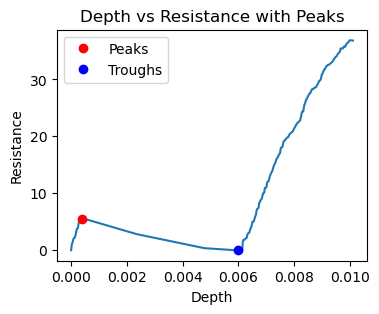

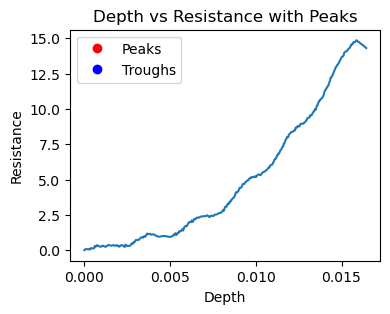

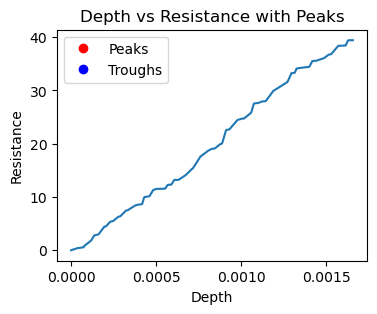

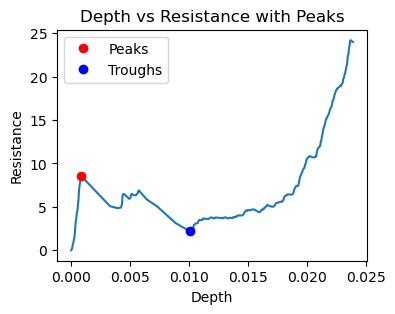

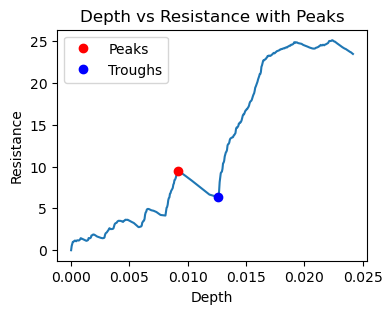

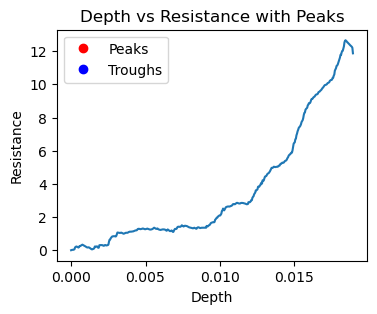

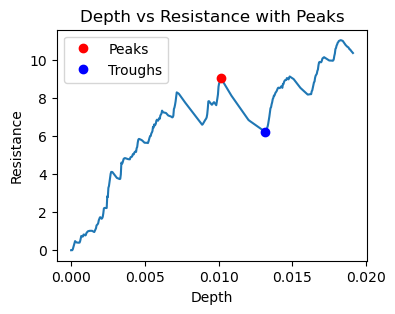

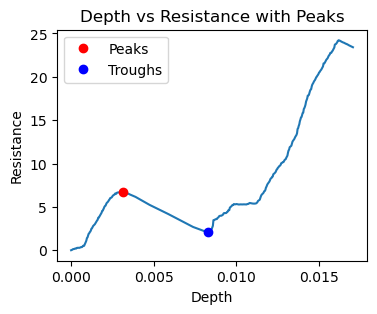

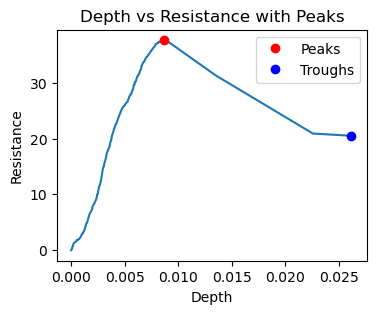

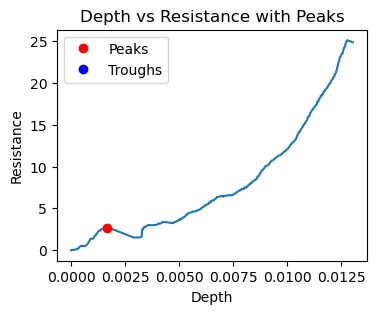

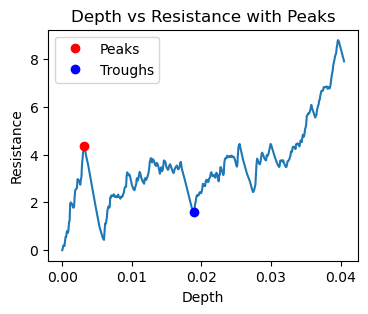

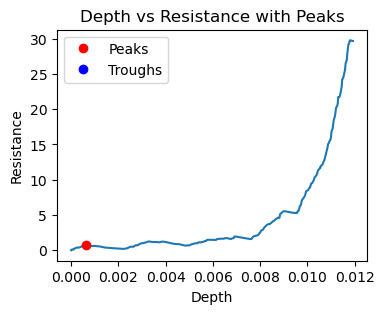

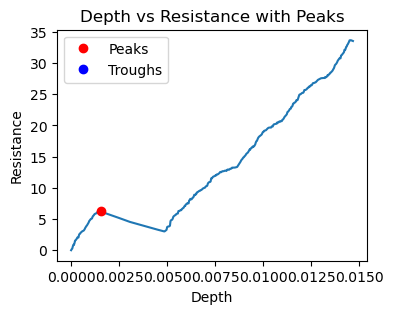

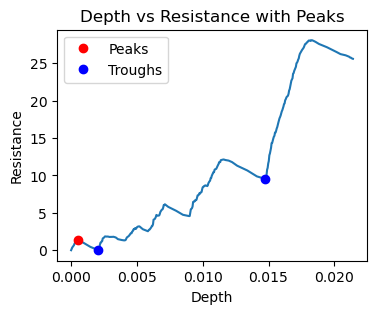

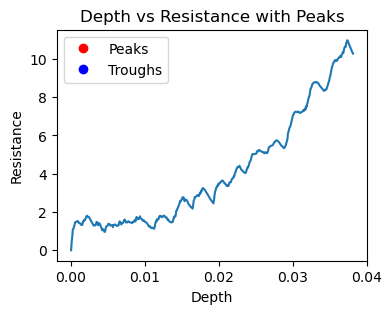

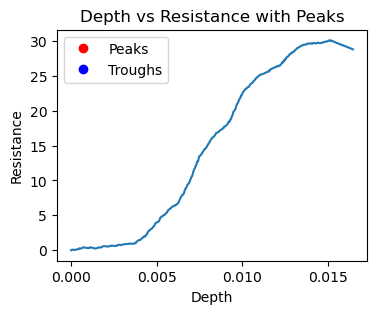

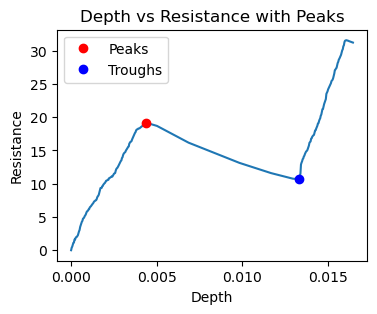

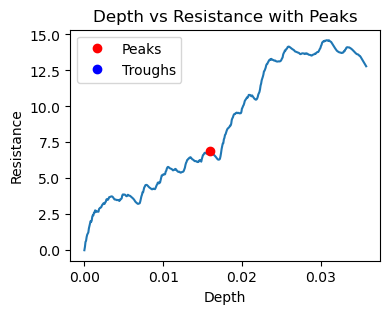

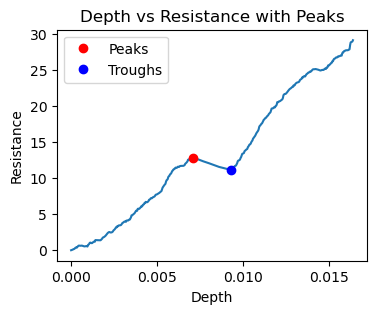

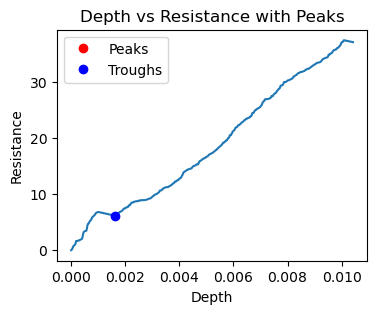

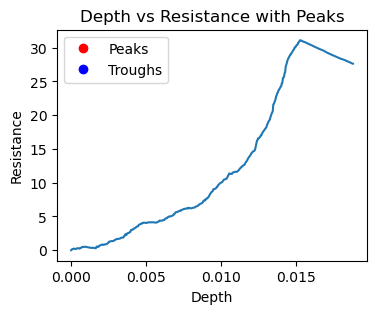

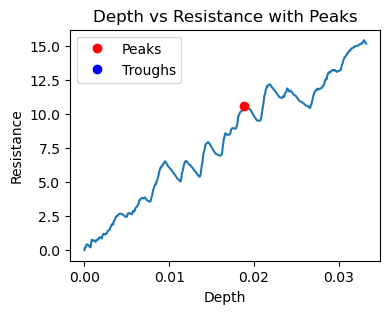

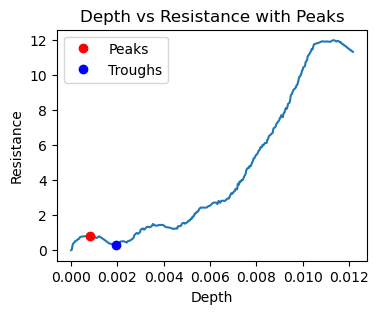

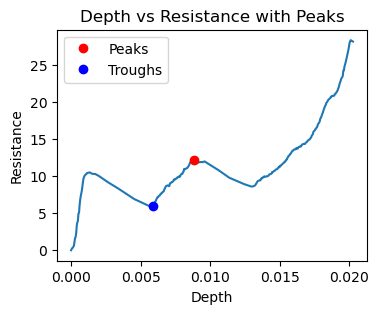

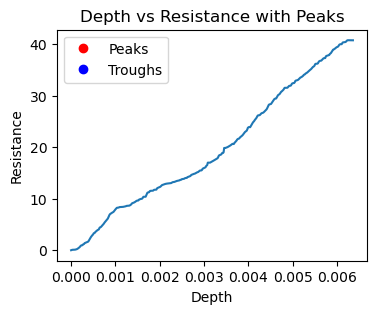

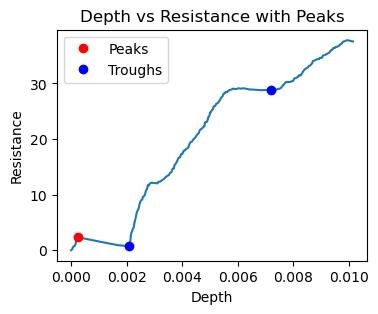

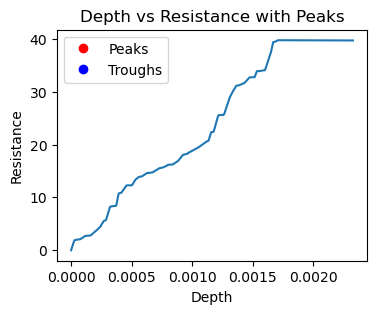

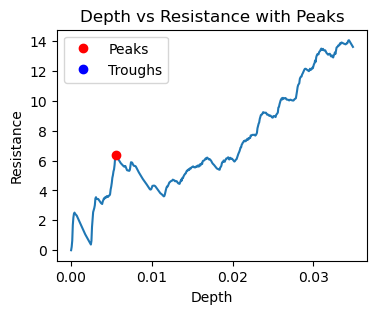

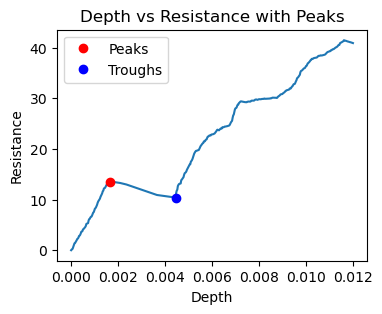

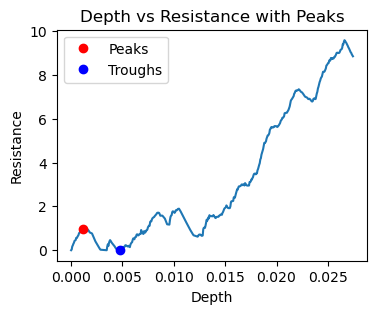

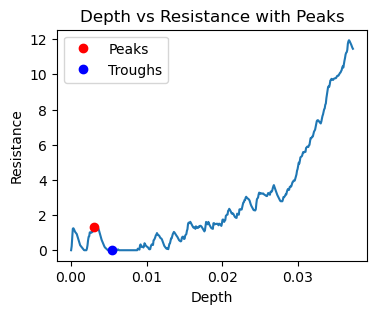

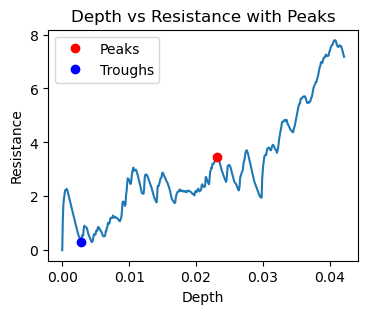

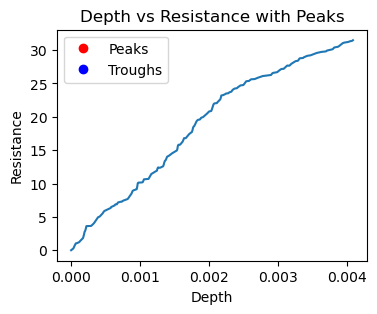

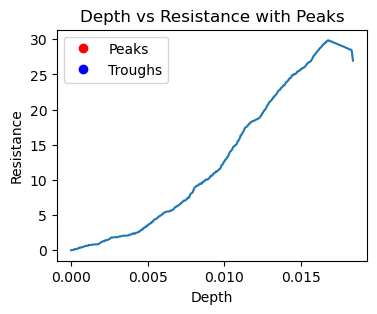

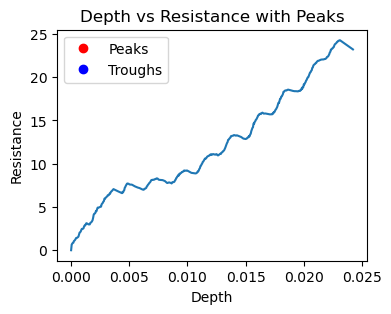

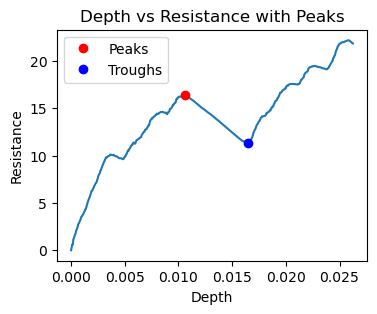

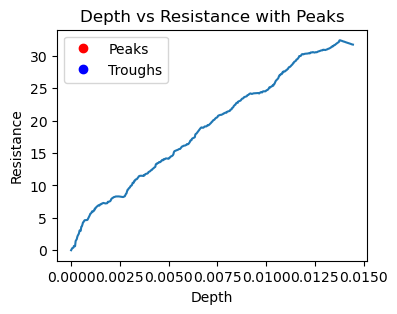

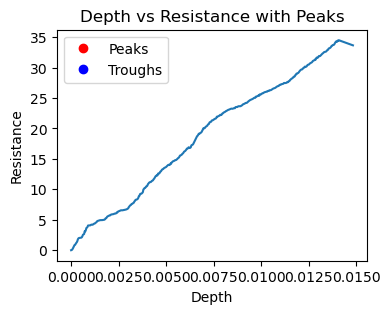

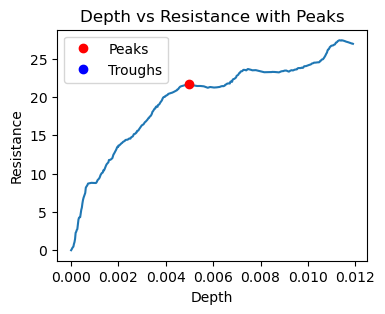

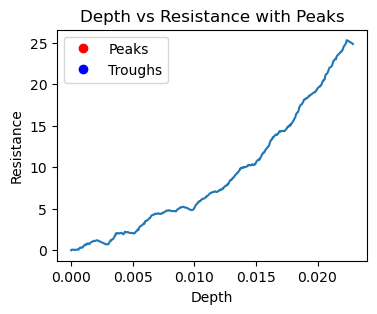

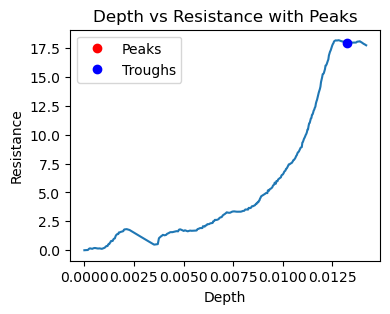

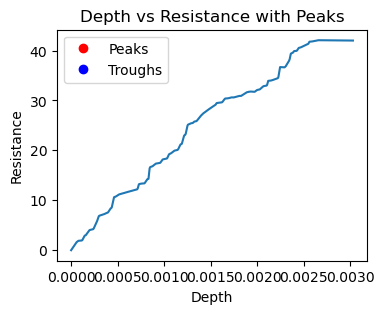

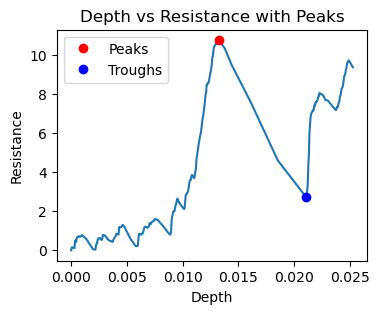

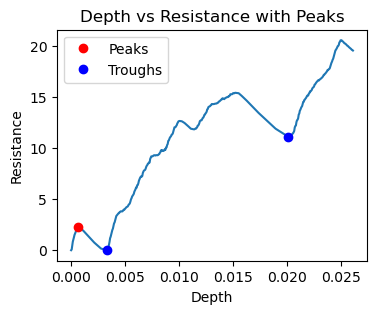

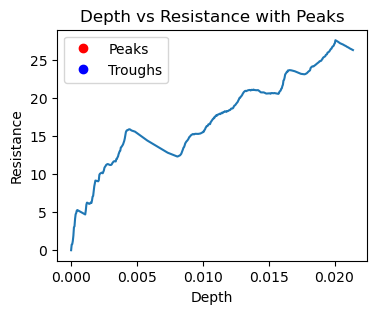

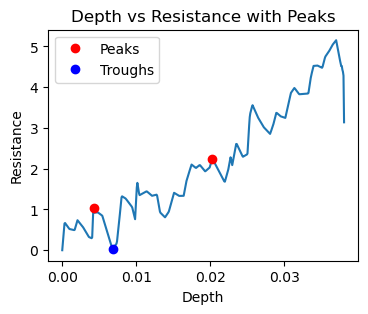

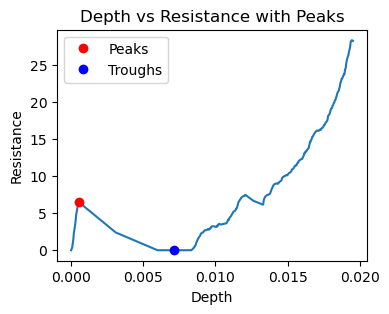

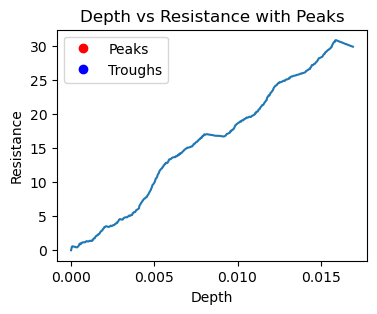

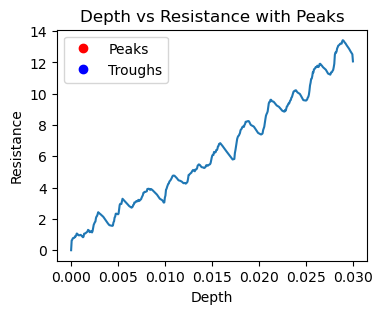

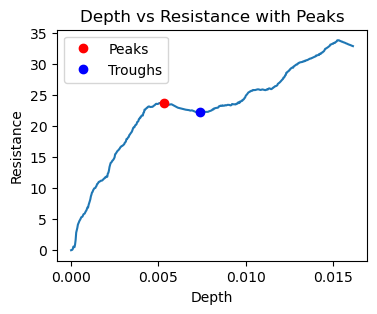

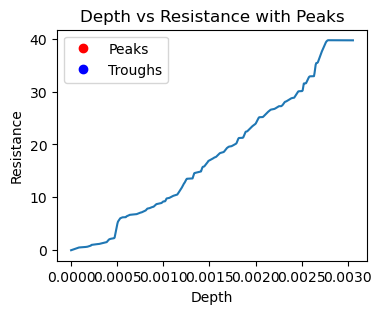

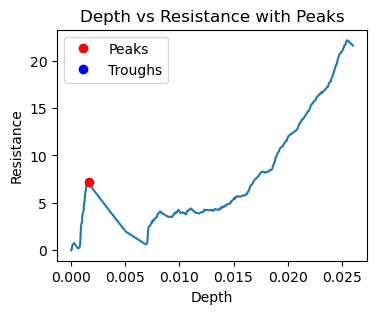

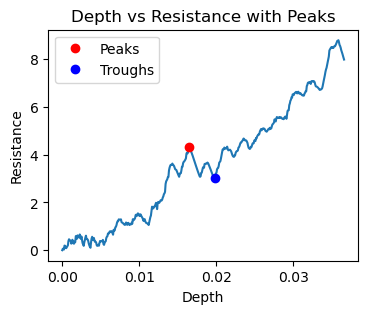

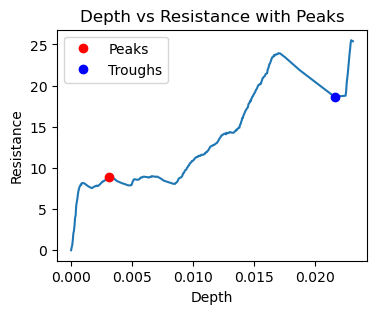

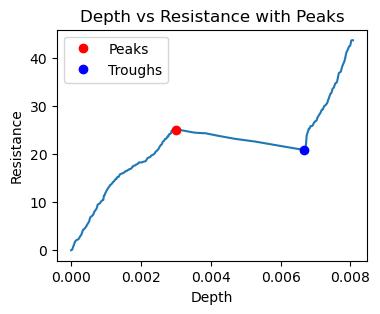

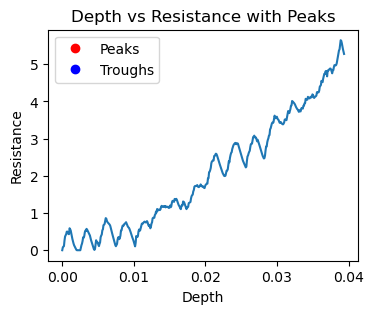

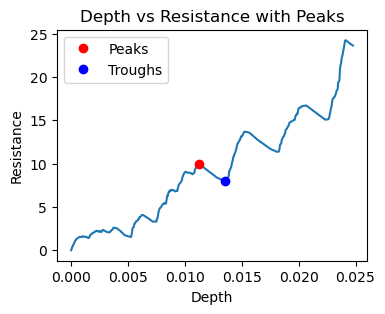

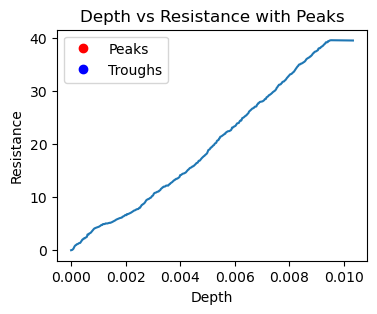

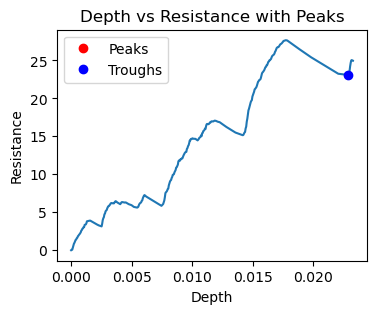

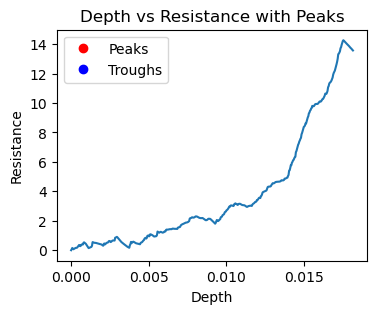

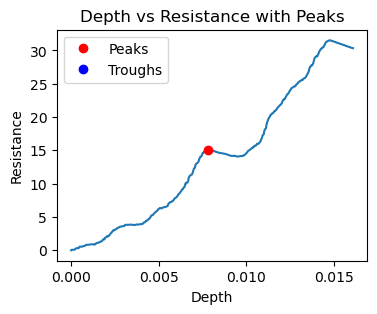

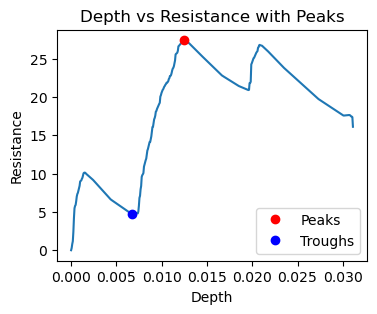

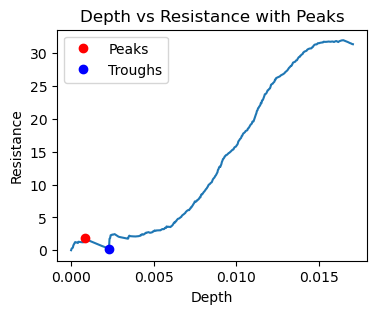

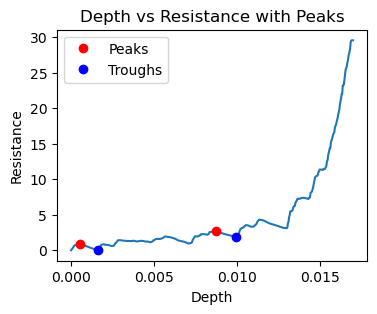

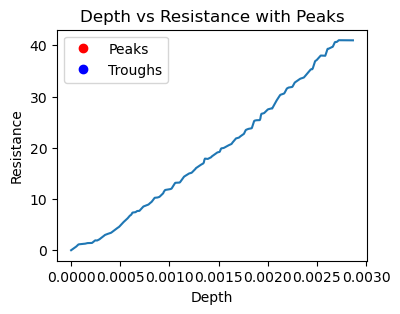

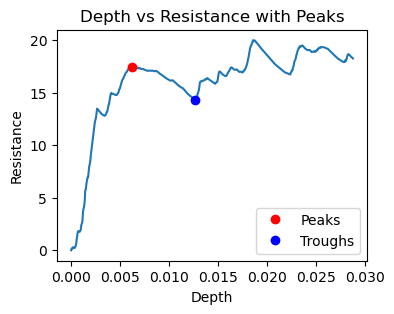

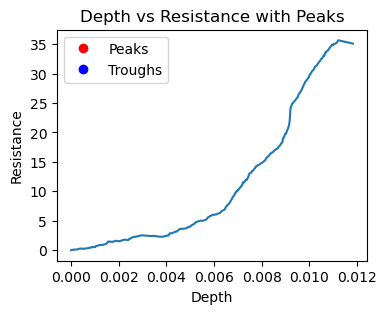

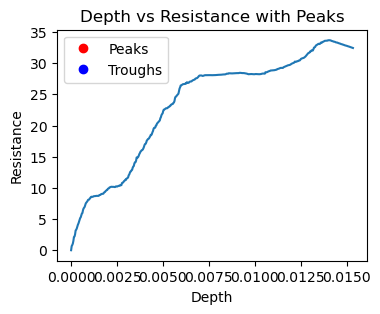

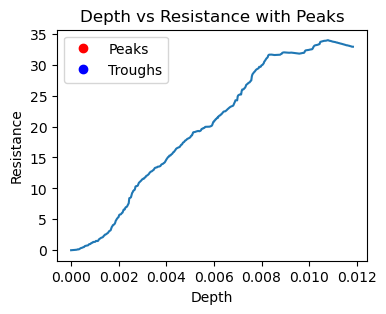

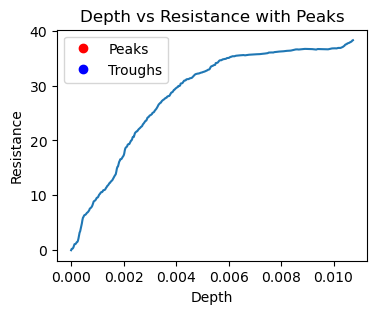

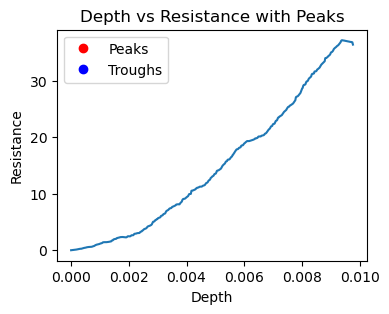

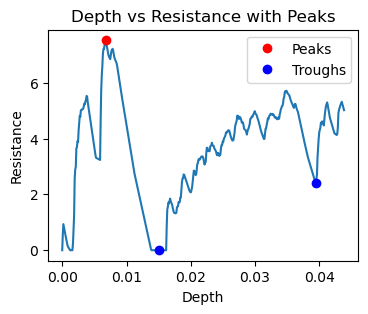

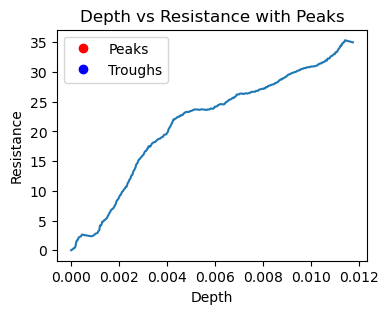

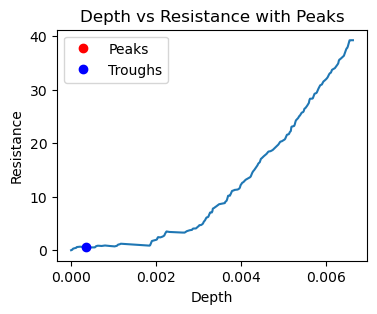

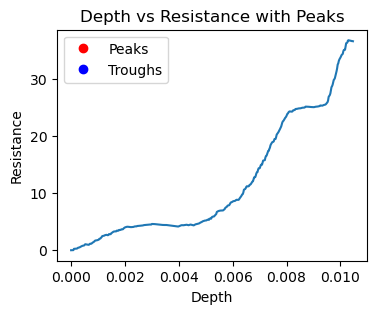

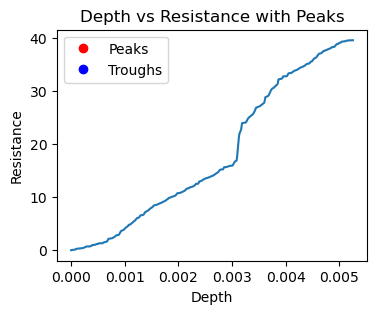

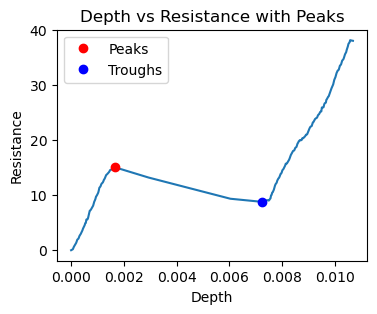

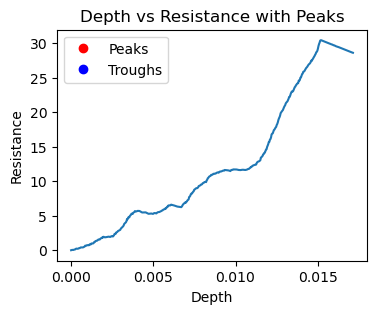

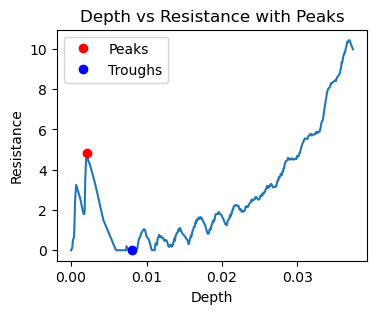

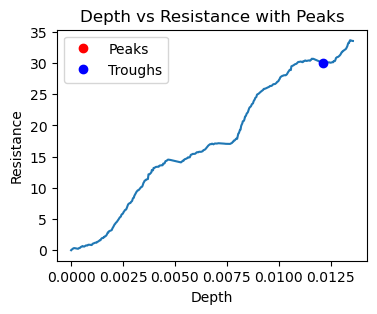

example:    res_mean        slope  overall_depth  overall_resistance
0   9.91018  3650.271525       0.010103           36.879028


In [135]:

def extract_simple_features(df):
    res = df["resistance"]
    dep = df["depth"]
    peaks, troughs = get_yield_force(df)
    return pd.DataFrame([{
        "res_mean": res.mean(),
        # "peaks": peaks[0] if len(peaks) > 0 else 0,
        "slope": res.max() / dep.max(),
        "overall_depth": dep.max(),
        "overall_resistance": res.max(),
        # "num_peaks": len(peaks),
        # "heterogeneity": heterogeneity(df, surface_fraction=0.2)
    }])

# shape (n,m) where n is number of df and m is extracted feaetures
representation_list = []
for i, df in enumerate(df_list):
    extracted_simple_features = extract_simple_features(df)
    representation_list.append(extracted_simple_features)
print(f"example: {representation_list[0]}")


# Correlation Matrix

In [136]:
representation_df  = pd.concat(representation_list, axis=0, ignore_index=True)
corr_matrix = representation_df.corr()
print(corr_matrix)

                    res_mean     slope  overall_depth  overall_resistance
res_mean            1.000000  0.517680      -0.640617            0.836085
slope               0.517680  1.000000      -0.657081            0.582620
overall_depth      -0.640617 -0.657081       1.000000           -0.833952
overall_resistance  0.836085  0.582620      -0.833952            1.000000


# Visualize Extracted Features Histograms

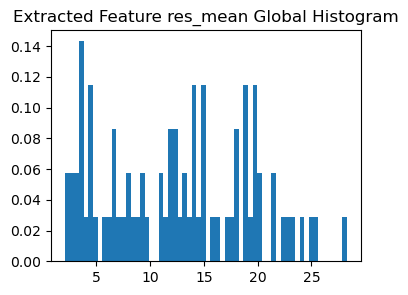

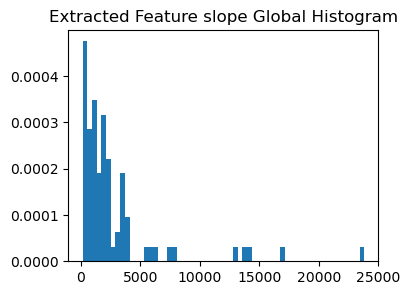

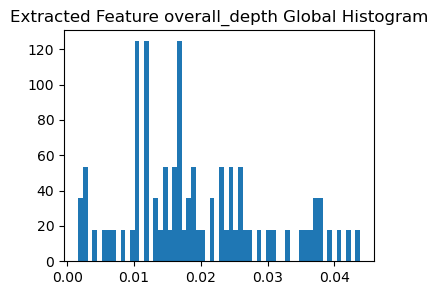

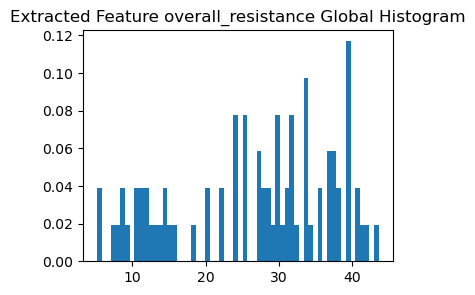

In [137]:
# representation_df  = pd.concat(representation_list, axis=0, ignore_index=True)
# # print(representation_df)
def plot_feature_dist(representation_df):
    for col in representation_df.columns:
        plt.figure(figsize=(4,3))
        plt.hist(representation_df[col], bins=60, density=True)
        plt.title(f"Extracted Feature {col} Global Histogram")
        plt.show()
plot_feature_dist(representation_df)

# Scale Features

   res_mean     slope  overall_depth  overall_resistance
0 -0.400019  0.796983      -0.876866            0.953243
1 -1.129303 -0.450450      -0.268884           -1.109515
2  1.064095  2.472979      -1.687413            1.192970
3 -0.852479 -0.348353       0.446678           -0.233552
4 -0.013154 -0.326111       0.471196           -0.151548


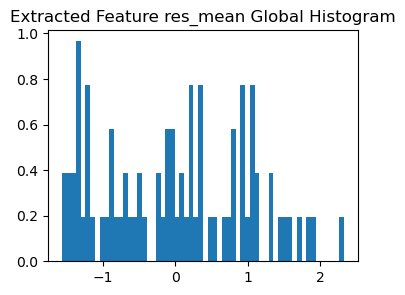

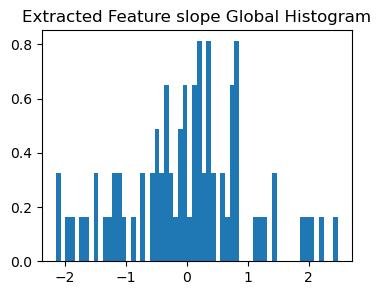

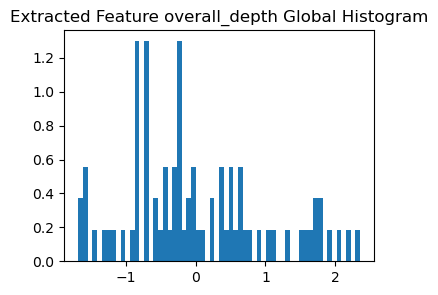

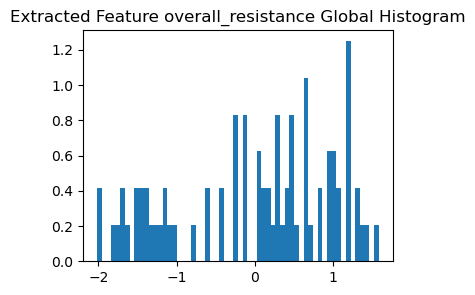

In [138]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def transform_features(df):
    df = df.copy()  # avoid modifying original
    # Apply cube root to 'slope'
    if "slope" in df.columns: df['slope'] = np.log(df['slope'])
    # if "yield_force" in df.columns: df['yield_force'] = df["yield_force"]
    # if "skew" in df.columns: df["skew"] = df["skew"] ** 1.1
    # if "kurtosis" in df.columns: df["kurtosis"] = np.sqrt(df["kurtosis"]) 
    # Standardize
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

scaled_representations = transform_features(representation_df)
print(scaled_representations[:5])
plot_feature_dist(scaled_representations)


# Save representation

In [139]:
scaled_representations.to_csv(f"data/features.csv", index=False)